In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pickle
import numpy as np

import py21cmfast as p21c
from astropy.cosmology import Planck18
from scipy import interpolate

sys.path.append("..")
from dm21cm.dm_params import DMParams
from dm21cm.evolve import evolve
import dm21cm.physics as phys

sys.path.append(os.environ['DH_DIR'])
from darkhistory.main import evolve as evolve_DH

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file('../matplotlibrc')

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


## DMParam

In [2]:
dm_params = DMParams(
    mode = 'swave',
    primary = 'phot_delta',
    m_DM = 1e10,
    sigmav = 1e-22,
    struct_boost_model = 'erfc 1e-3',
)

## DarkHistory

In [6]:
run_name = 'dhc_phph_adia'

soln = evolve_DH(
    DM_process=dm_params.mode, mDM=dm_params.m_DM,
    primary=dm_params.primary,
    sigmav=dm_params.sigmav, lifetime=dm_params.lifetime,
    struct_boost=dm_params.struct_boost,
    start_rs=3000, end_rs=4.+1, coarsen_factor=12, verbose=1,
    # use fake reionization to get case-A recomb. coeff.
    reion_switch=True, reion_rs=46.,
    photoion_rate_func=[lambda x: 0., lambda x: 0., lambda x: 0.],
    photoheat_rate_func=[lambda x: 0., lambda x: 0., lambda x: 0.],
    debug=False,
    debug_turnoff_injection_rs = 46,
)

pickle.dump(soln, open(f"run_info/{run_name}_dh_soln.p", 'wb'))

****** Loading transfer functions... ******
Using data at /n/holyscratch01/iaifi_lab/yitians/darkhistory/DHdata_v1_1
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******
Loading time: 9.677 s


  0%|          | 0/534 [00:00<?, ?it/s]

Initialization time: 0.064 s


 10%|█         | 54/534 [00:07<01:13,  6.55it/s]/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
100%|██████████| 534/534 [01:23<00:00,  6.36it/s]


Main loop time: 83.964 s


In [3]:
run_name = 'dhc_phph_adia'
dh_soln = pickle.load(open(f"run_info/{run_name}_dh_soln.p", 'rb'))
dh_xe_interp_func = lambda z: interpolate.interp1d(dh_soln['rs']-1, dh_soln['x'][:, 0])(z).item()

In [4]:
dm_params = DMParams(
    mode = 'swave',
    primary = 'phot_delta',
    m_DM = 1e10,
    sigmav = 1e-50,
    struct_boost_model = 'erfc 1e-3',
)

return_dict = evolve(
    run_name = 'dhc_phph_adia',
    z_start = 45.,
    z_end = 5.,
    zplusone_step_factor = 1.01,
    dm_params = dm_params,
    enable_elec = False,
    tf_version = '230629',
    
    p21c_initial_conditions = p21c.initial_conditions(
        user_params = p21c.UserParams(
            HII_DIM = 16,
            BOX_LEN = 16 * 4, # [conformal Mpc]
            N_THREADS = 32,
        ),
        cosmo_params = p21c.CosmoParams(
            OMm = Planck18.Om0,
            OMb = Planck18.Ob0,
            POWER_INDEX = Planck18.meta['n'],
            #SIGMA_8 = Planck18.meta['sigma8'],
            SIGMA_8 = 1e-8,
            hlittle = Planck18.h,
        ),
        random_seed = 54321,
        write = True,
    ),
    
    rerun_DH = False,
    clear_cache = True,
    use_tqdm = False,
    debug_flags = ['uniform_xray'],
    debug_xray_multiplier = 1.,
    debug_astro_params = p21c.AstroParams(
        L_X = 0. # log10 value
    ),
    save_dir='run_info',
    debug_dhc_DH_xe_func=dh_xe_interp_func,
    debug_dhc_delta_one=True,
)
        

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/inputs.py:487: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(
INFO:root:Using 21cmFAST version 0.1.dev1581+g40959ca.d20230929
INFO:root:Cache dir: /n/holyscratch01/iaifi_lab/yitians/21cmFAST-cache/dhc_phph_adia
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter CUDA
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO:root:TransferFunctionWrapper: Loaded photon transfer functions.
INFO:root:DarkHistoryWrapper: Found existing DarkHistory init

get_init_cond 909.5963702779808 0.02347762056056839
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
box_ct = 0
dzp = -3.170662e-01
zp = 4.467847e+01
dt_dzp = -5.811694e+13
dadia_dzp * dzp = -5.655185e-01
dspec_dzp * dzp = 0.000000e+00
dcomp_dzp * dzp = 3.589178e-02
dxheat_dzp * dzp = 0.000000e+00
input heating = 0.000000e+00
dxion_source = 0.000000e+00
dxion_sink = 2.259717e-07
T = 4.073600e+01
alpha_A(T) = 1.492184e-11
global_params.CLUMPING_FACTOR = 1.000000e+00
x_e = 2.129700e-04
f_H = 9.249617e-01
prefactor_1 = 1.958927e-02
curr_delNL0 = -2.138955e-06
growth_factor_zp = 2.786624e-02
input ionization = 0.000000e+00

N_b0 = 2.055340e-07
f_H = 9.249617e-01

before 909.59644 0.023477616
input_heating 0.0
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
box_ct = 0
dzp = -4.522629e-01
zp = 4.422620e+01
dt_dzp = -5.958076e+13
dadia_dzp * dzp = -1.819196e+01
dspec_dzp * dzp = 0.000000e+00
dcomp_dzp * dzp = -5.101898e+01
d

## compare

In [5]:
def plot_global(dh_soln, soln):
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))

    color_dict = {
        'DH' : 'k',
        '21' : 'r',
    }

    z_plot_start = 50.
    i_z_st = np.argmin(np.abs(dh_soln['rs']-1 - z_plot_start))
    ax = axs[0,0]
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_soln['Tm'][i_z_st:]/phys.kB, color=color_dict['DH'], label='DarkHistory')
    ax.plot(soln['z'], soln['T_k'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.plot(soln['z'][0], soln['T_k'][0], color=color_dict['21'], marker='+', ms=5)
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$T_k$ [K]', title='Gas temperature')
    ax.legend()

    ax = axs[0,1]
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_soln['x'][i_z_st:, 0], color=color_dict['DH'], label='DH HII')
    #ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_soln['x'][i_z_st:, 1], color='b', label='DH HeII')
    ax.plot(soln['z'], soln['x_e'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.plot(soln['z'][0], soln['x_e'][0], color=color_dict['21'], marker='+', ms=5)
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$x_e$', title='$x_e$')
    ax.legend()

    ax = axs[0,2]
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_soln['x'][i_z_st:, 0], color=color_dict['DH'], label='DH HII')
    #ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_soln['x'][i_z_st:, 1], color='b', label='DH HeII')
    ax.plot(soln['z'], soln['1-x_H'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.plot(soln['z'][0], soln['1-x_H'][0], color=color_dict['21'], marker='+', ms=5)
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$1-x_H$', title='$1-x_H$')
    ax.legend()

    ax = axs[0,3]
    ax.plot(soln['z'], soln['T_b'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.set(xlim=(5, 50), xscale='log')
    ax.set(xlabel='$z$', ylabel='$T_b$ [K]', title='Brightness temperature')

    ax = axs[1,0]
    dh_bath_engs = [s.toteng() for s in dh_soln['highengphot']]
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_bath_engs[i_z_st:], color=color_dict['DH'], label='DarkHistory')
    ax.plot(soln['z'], soln['E_phot'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.plot(soln['z'][0], soln['E_phot'][0], color=color_dict['21'], marker='+', ms=5)
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$E$ [eV/Bavg]', title='Bath energy')

    ax = axs[1,1]
    dh_fs = dh_soln['f']['low']['heat'] + dh_soln['f']['high']['heat']
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_fs[i_z_st:], color=color_dict['DH'], label='DarkHistory')
    ax.plot(soln['z'], soln['f_heat'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$f$', title=r'$f\mathrm{heat}$')

    ax = axs[1,2]
    dh_fs = dh_soln['f']['low']['H ion'] + dh_soln['f']['high']['H ion'] + dh_soln['f']['low']['He ion'] + dh_soln['f']['high']['He ion']
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_fs[i_z_st:], color=color_dict['DH'], label='DarkHistory')
    ax.plot(soln['z'], soln['f_ion'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$f$', title=r'$f\mathrm{ion}$')

    ax = axs[1,3]
    dh_fs = dh_soln['f']['low']['exc'] + dh_soln['f']['high']['exc']
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_fs[i_z_st:], color=color_dict['DH'], label='DarkHistory')
    ax.plot(soln['z'], soln['f_exc'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$f$', title=r'$f\mathrm{exc}$')

44.67846508307498

In [17]:
zs = np.linspace(5, np.max(soln['z']), 100)
dh_Ts = interpolate.interp1d(dh_soln['rs']-1, dh_soln['Tm']/phys.kB)(zs)
p21c_Ts = interpolate.interp1d(soln['z'], soln['T_k'])(zs)
p21c_Ts / dh_Ts

array([0.91585355, 0.91749776, 0.91903799, 0.92049123, 0.92186817,
       0.92315625, 0.92438837, 0.92558262, 0.9266656 , 0.9277374 ,
       0.92876002, 0.92975061, 0.9306542 , 0.93154207, 0.93240823,
       0.93323204, 0.93398257, 0.93474744, 0.93549525, 0.9361707 ,
       0.93685082, 0.93748614, 0.93809517, 0.93870851, 0.93928335,
       0.93985729, 0.94038717, 0.94090761, 0.94137966, 0.94186085,
       0.94230783, 0.94272814, 0.94313527, 0.94354996, 0.94394762,
       0.94429749, 0.94466385, 0.94500341, 0.94529907, 0.94566222,
       0.94592565, 0.94625887, 0.94647305, 0.94674249, 0.94696023,
       0.94720931, 0.94741298, 0.94759183, 0.9478161 , 0.9479586 ,
       0.94812678, 0.94825028, 0.94847822, 0.94852735, 0.94866013,
       0.94871701, 0.94889076, 0.94900488, 0.94905684, 0.94911782,
       0.94911053, 0.94918756, 0.94925798, 0.94926528, 0.94930999,
       0.94940765, 0.94945004, 0.94943861, 0.94946936, 0.94957054,
       0.94963144, 0.94965645, 0.94965071, 0.94962042, 0.94973

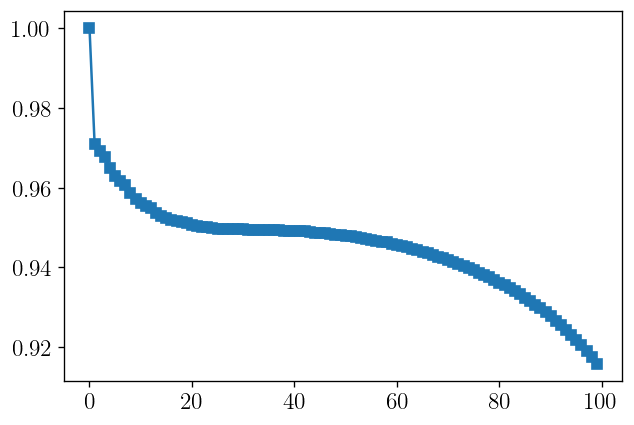

In [18]:
rat = p21c_Ts / dh_Ts

plt.plot(rat[::-1], '-s')

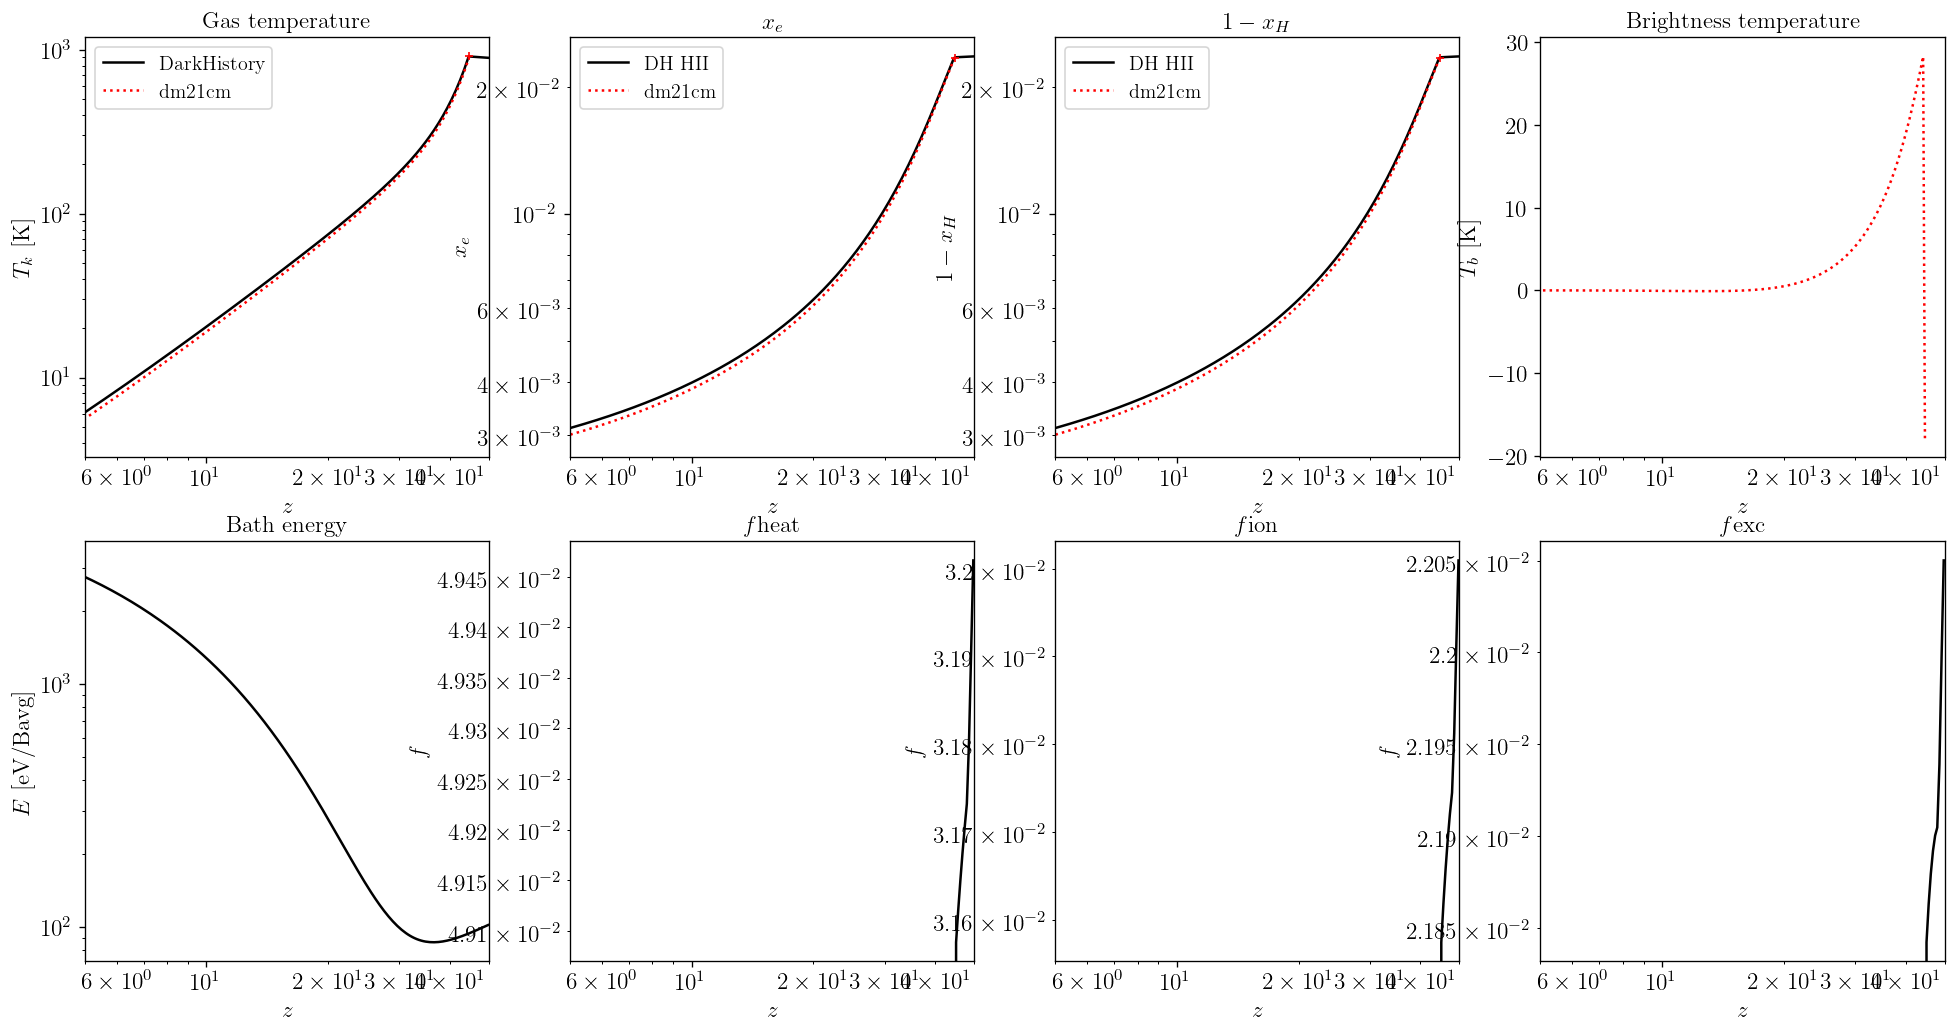

In [6]:
run_name = 'dhc_phph_adia'
dh_soln = pickle.load(open(f"run_info/{run_name}_dh_soln.p", 'rb'))
run_name = 'dhc_phph_adia'
soln = np.load(f"run_info/{run_name}_records.npy", allow_pickle=True).item()
plot_global(dh_soln, soln)

In [ ]:
dh_soln['f']['low'].keys()

dict_keys(['H ion', 'He ion', 'exc', 'heat', 'cont'])

In [ ]:
zs = np.linspace(5.001, 44.999, 100)
dh_fs = dh_soln['f']['low']['heat'] + dh_soln['f']['high']['heat']
dh_arr = np.interp(1+zs, dh_soln['rs'][::-1], dh_fs[::-1])
p21c_arr = np.interp(zs, soln['z'][::-1], soln['f_heat'][::-1])
np.max(np.abs(p21c_arr-dh_arr)/dh_arr)

0.1376472167124593

In [ ]:
zs = np.linspace(5.001, 44.999, 100)
dh_bath_engs = [s.toteng() for s in dh_soln['highengphot']]
dh_arr = np.interp(1+zs, dh_soln['rs'][::-1], dh_bath_engs[::-1])
p21c_arr = np.interp(zs, soln['z'][::-1], soln['E_phot'][::-1])
np.max(np.abs(p21c_arr-dh_arr)/dh_arr)

0.05427165381579362

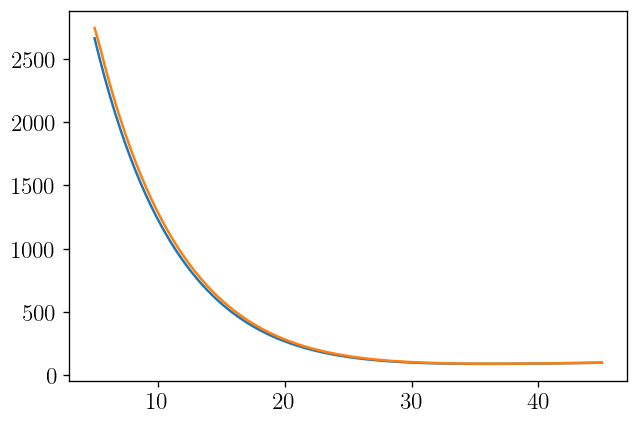

In [ ]:
plt.plot(zs, p21c_arr)
plt.plot(zs, dh_arr)
